In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from pypalettes import load_cmap
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress, pearsonr
from datetime import datetime, timedelta
import ruptures as rpt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

In [2]:
# Active Storage are included in the folder 'ReservoirsOriginal'

reservoirID = [2,3,4,5,6,7,8,9,11,13,14,16,17,18,19,20,21,22,24,25,26,28,29,36,37,101,108,109]

year = {}
os.chdir('ReservoirsOriginal')
# Iterate through the vector
for i in reservoirID:
    # Create the file name
    nome_file = f"res{i}.txt"

    # Open the file and read the lines
    with open(nome_file, 'r') as file:
        file.readline()  
        riga = file.readline().strip()  

    
    elements = riga.split()

    # Extract the required values (active storage and start year of operation) 
     
    year[i] = int(elements[6])   
os.chdir('..')   

In [3]:
# Function to interpolate a colormap using cubic interpolation:
def interpolate_cmap(cmap, num_interp_points):
    new_colors = cmap(np.linspace(0, 1, cmap.N))  # Ottieni i colori della colormap discreta
    new_cmap = LinearSegmentedColormap.from_list('my_interpolated_cmap', new_colors, N=num_interp_points)
    return new_cmap

In [4]:
# In Results folder (1-16) we have the results of the paragraph 'Cumulative Dam Impacts on 3S Sediment Flow'
num_folders = 16
num_columns = 7
num_rows = 8401  # Not used here but included for reference
outsed = np.zeros((num_folders, 23))

# Loop through folders
for folder_idx in range(1, num_folders + 1):
    folder_name = f'Results{folder_idx}'
    
    # Change directory to the folder
    os.chdir(folder_name)
    
    # Read the CSV file containing the annual sediment loads
    totsedyear = np.loadtxt('totsedyear.csv', delimiter=',')  # Use pandas if needed
    outsed[folder_idx - 1, :] = totsedyear[:]  # Adjusted for 0-based indexing
    
    # Return to the parent directory
    os.chdir('..')

# Create the years vector
yearsed = np.arange(2000, 2023)  
yearcap = np.arange(2000, 2023)

# Calculate medians and confidence intervals of annual sediment loads over the 16 scenarios
medians = np.median(outsed, axis=0)
conf_intervals = np.zeros((23, 2))
for i in range(23):
    conf_intervals[i, :] = np.percentile(outsed[:, i], [25, 75])


In [5]:

# Active Storage are included in the folder 'ReservoirsOriginal'
vettore = [9, 8, 7, 6, 5, 4, 3, 37, 36, 2, 29, 28, 26, 25, 24, 22, 21, 20, 19, 18, 17, 16, 14, 13, 11, 101, 108, 109]

# Initialize storage and year dictionaries
storage = {}
year = {}
os.chdir('ReservoirsOriginal')
# Iterate through the vector
for i in vettore:
    # Create the file name
    nome_file = f"res{i}.txt"

    # Open the file and read the lines
    with open(nome_file, 'r') as file:
        file.readline()  
        riga = file.readline().strip()  

    
    elementi = riga.split()

    # Extract the required values (active storage and start year of operation) 
    storage[i] = float(elementi[2])  
    year[i] = int(elementi[6])       

# Initialize years and cumulative storage arrays
anni = np.arange(1985, 2024)
cumulative_storage = np.zeros((3, len(anni)))

# Iterate through the years
for idx, current_year in enumerate(anni):
    
    cumulative_storage_year = np.zeros(3)

    # Iterate through the reservoirs
    for reservoir_id in vettore:
        # Check if the current year is greater than the reservoir's start year
        if current_year > year[reservoir_id]:
            if reservoir_id in [101, 7, 20, 11, 8, 9, 21, 109, 108]:
                cumulative_storage_year[0] += storage[reservoir_id]
            elif reservoir_id in [36, 37, 13, 14, 16, 17, 18]:
                cumulative_storage_year[1] += storage[reservoir_id]
            else:
                cumulative_storage_year[2] += storage[reservoir_id]

    # Assign cumulative storage for the current year
    cumulative_storage[:, idx] = cumulative_storage_year

# Convert cumulative storage to desired units (km³)
cumulative_storage = cumulative_storage * 1000 / 1e9



# Sum of cumulative storage
ActiveStorage = cumulative_storage.sum(axis=0)
os.chdir('..')

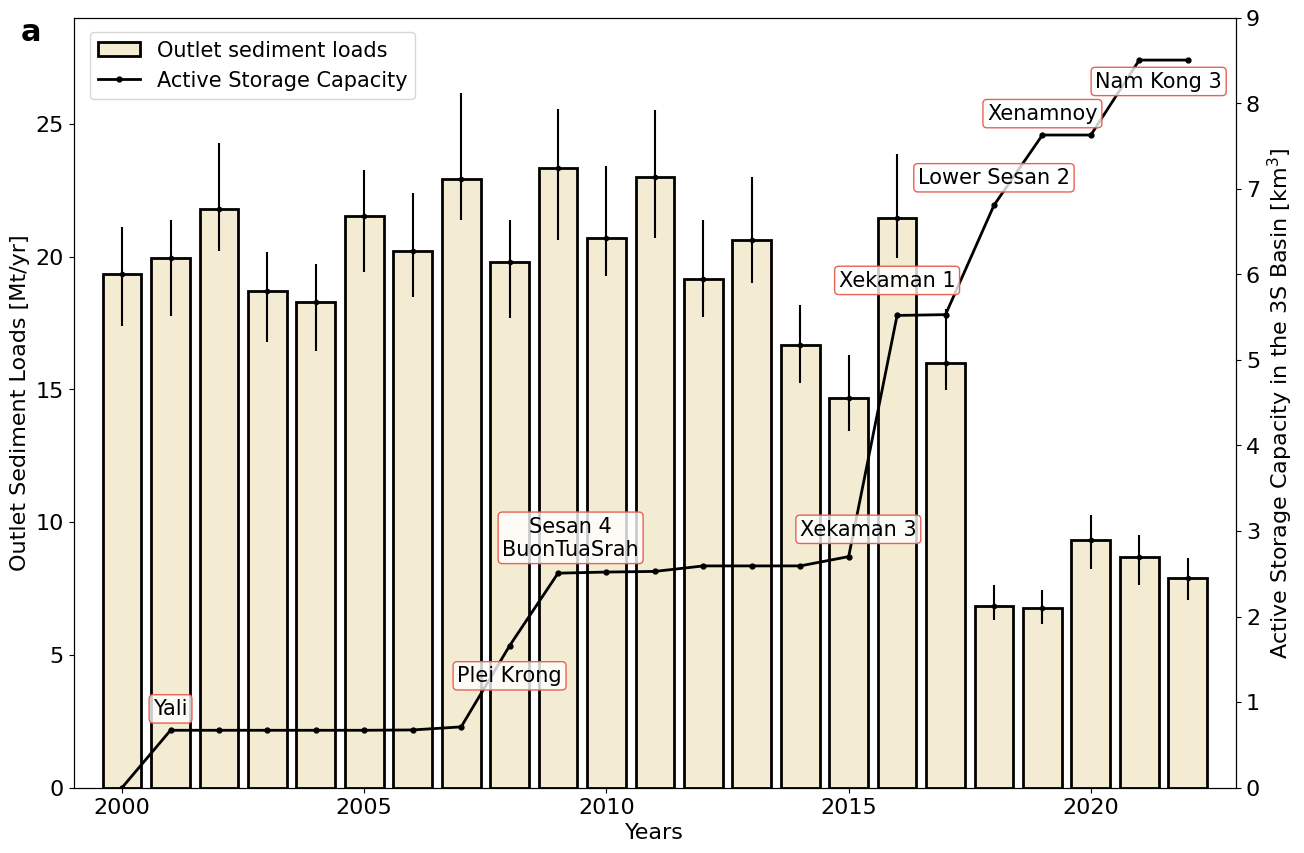

In [12]:
# Plot of Figure 2a


cmap = load_cmap("Hiroshige")
cmap = interpolate_cmap(cmap, 1000)
fig = plt.figure(figsize=(15, 10))

# Left y-axis
#plt.bar(yearsed[:], medians[:], edgecolor=cmap(0.98,1), facecolor=cmap(0.465,0.7), linewidth=2, label='Mediana')
bar_plot = plt.bar(yearsed[:], medians[:], edgecolor='black', facecolor=cmap(0.465,0.7), linewidth=2, label='Mediana')
error_plot = plt.errorbar(yearsed[:], medians[:], yerr=[medians[:] - conf_intervals[:,0], conf_intervals[:,1] - medians[:]], 
             fmt='.', color='k', linewidth=1.5, label='Intervallo di confidenza')

plt.xlabel('Years',fontsize=16)
plt.ylabel('Outlet Sediment Loads [Mt/yr]',fontsize=16)
plt.xlim([1999, 2023])
plt.ylim([0, 29])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.gca().yaxis.label.set_color(cmap(0.98))
plt.gca().yaxis.label.set_color('black')
# Right y-axis
plt.twinx()

#plt.plot(yearcap[:], ActiveStorage[-23:], '-o', color=cmap(1), linewidth=1.5, 
#         markersize=3, markerfacecolor=cmap(1))
line_plot, = plt.plot(yearcap[:], ActiveStorage[-23:], '-o', color='black', linewidth=2, 
         markersize=3.5, markerfacecolor='black')
plt.ylabel('Active Storage Capacity in the 3S Basin [km$^3$]',fontsize=16)
plt.ylim([0, 9])
#plt.gca().yaxis.label.set_color(cmap(1))
plt.gca().yaxis.label.set_color('black')
#plt.gca().invert_yaxis()
plt.yticks(fontsize=16)

#plt.annotate(annotation.items()['text'])
#for pos, text_info in annotations.items():
plt.annotate('Yali', (2001, ActiveStorage[39 - 2022 + 2001] + 0.4),
                 xytext=(2001, ActiveStorage[2001 + 39 - 2022] + 0.25),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Plei Krong', (2008, ActiveStorage[39 - 2022 + 2008] - 1.2),
                 xytext=(2008, ActiveStorage[2008 + 39 - 2022] - 1.2),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Sesan 4\nBuonTuaSrah', (2009.26, ActiveStorage[39 - 2022 + 2009] + 0.4),
                 xytext=(2009.26, ActiveStorage[2009 + 39 - 2022] + 0.4),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Xekaman 3', (2015.2, ActiveStorage[39 - 2022 + 2015] - 2.5),
                 xytext=(2015.2, ActiveStorage[2015 + 39 - 2022] - 2.5),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Xekaman 1', (2016, ActiveStorage[39 - 2022 + 2016] + 0.4),
                 xytext=(2016, ActiveStorage[2016 + 39 - 2022] + 0.4),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Lower Sesan 2', (2018, ActiveStorage[39 - 2022 + 2018] - 0.5),
                 xytext=(2018, ActiveStorage[2018 + 39 - 2022] - 0.5),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Nam Kong 3', (2021.4, ActiveStorage[39 - 2022 + 2021] -0.25),
                 xytext=(2021.4, ActiveStorage[2021 + 39 - 2022] - 0.25),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))

plt.annotate('Xenamnoy', (2019, ActiveStorage[39 - 2022 + 2019] + 0.25),
                 xytext=(2019, ActiveStorage[2019 + 39 - 2022] + 0.25),
                 fontsize=15, ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor=[1, 1, 1 ,0.8], edgecolor=cmap(1,1)))


# Adding arrow annotation
#plt.annotate('', xy=(0.8142, 0.82), xytext=(0.8142, 0.3), xycoords='figure fraction',
#             arrowprops=dict(arrowstyle='<-', color=cmap(1), linewidth=2))
#plt.annotate('', xy=(0.8262, 0.82), xytext=(0.8262, 0.4), xycoords='figure fraction',
#             arrowprops=dict(arrowstyle='<-', color='black', linewidth=1.8))
#plt.annotate('', xy=(0.0718, 0.82), xytext=(0.0718, 0.4), xycoords='figure fraction',
#             arrowprops=dict(arrowstyle='->', color='black', linewidth=1.7))
# Adding the legend
plt.text(0.09, 0.88, 'a', fontsize=22, ha='left', va='top', fontweight='bold', transform=plt.gcf().transFigure)

plt.legend(handles=[bar_plot, line_plot], 
           labels=['Outlet sediment loads', 'Active Storage Capacity'], bbox_to_anchor=(0.303, 0.995), fontsize=15)
fig.savefig('Figure2a.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

## Temporal Changes in Correlation between sediment and hydroclimatic variables (Figure 2b and c)

In [7]:

meandisch = np.zeros((1, 23))
disch_95 = np.zeros((1, 23))
outsed = np.zeros((1, 23))


#folder_name = f'Results{folder_idx}'
folder_name = 'Results12'
    # Change directory to the folder
os.chdir(folder_name)
    
discharge_file = '75STA.day'

# Assuming the file contains no headers and discharge values are in the 4th column
discharge_data = np.loadtxt(discharge_file, usecols=[3])

# Step 2: Define the date range (2000-01-01 to 2022-12-31) and create a date index
start_date = datetime(2000, 1, 1)
end_date = datetime(2022, 12, 31)
date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Verify that the length of discharge_data matches the date range
assert len(discharge_data) == len(date_range), "Mismatch between dates and discharge data!"

# Step 3: Group discharge data by year
# Create a DataFrame for easier handling
discharge_df = pd.DataFrame({'date': date_range, 'discharge': discharge_data})
discharge_df['year'] = discharge_df['date'].dt.year

# Calculate mean and 95th percentile discharge for each year
mean_annual_discharge = discharge_df.groupby('year')['discharge'].mean().values
p95_annual_discharge = discharge_df.groupby('year')['discharge'].quantile(0.95).values
meandisch[0,:] = mean_annual_discharge
disch_95[0,:] = p95_annual_discharge
# Step 4: Load the annual sediment load data
sediment_file = 'totsedyear.csv'
sediment_load = pd.read_csv(sediment_file, header=None).squeeze().values  # Assuming no headers
outsed[0,:] = sediment_load
# Step 5: Check if the data matches in length
assert len(mean_annual_discharge) == len(sediment_load), "Mismatch in data lengths!"
    
# Return to the parent directory
os.chdir('..')


In [8]:
num_folders = 16

meandisch = np.zeros((num_folders, 23))
disch_95 = np.zeros((num_folders, 23))
outsed = np.zeros((num_folders, 23))

# Loop through folders
for folder_idx in range(1, num_folders + 1):
    folder_name = 'Results12'
    os.chdir(folder_name)
    
    discharge_file = '75STA.day'
    discharge_data = np.loadtxt(discharge_file, usecols=[3])

    start_date = datetime(2000, 1, 1)
    end_date = datetime(2022, 12, 31)
    date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

    assert len(discharge_data) == len(date_range), "Mismatch between dates and discharge data!"

    discharge_df = pd.DataFrame({'date': date_range, 'discharge': discharge_data})
    discharge_df['year'] = discharge_df['date'].dt.year

    meandisch[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].mean().values
    disch_95[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].quantile(0.95).values
    
    sediment_file = 'totsedyear.csv'
    sediment_load = pd.read_csv(sediment_file, header=None).squeeze().values
    outsed[folder_idx-1, :] = sediment_load
    
    assert len(meandisch[folder_idx-1]) == len(sediment_load), "Mismatch in data lengths!"
    os.chdir('..')

# Calculation of the Median and Percentiles Across Folders for Each Year
meandisch_median = np.median(meandisch, axis=0)
meandisch_5 = np.percentile(meandisch, 5, axis=0)
meandisch_95 = np.percentile(meandisch, 95, axis=0)

outsed_median = np.median(outsed, axis=0)
outsed_5 = np.percentile(outsed, 5, axis=0)
outsed_95 = np.percentile(outsed, 95, axis=0)

blocks = [(2001, 2006), (2007, 2011), (2012, 2016), (2017, 2022)]
anni = np.arange(2000, 2023)

plt.figure(figsize=(15, 10))
s = 1

for start, end in blocks:
    mask = (anni >= start) & (anni <= end)
    
    x_median = meandisch_median[mask]
    x_5 = meandisch_5[mask]
    x_95 = meandisch_95[mask]
    y_median = outsed_median[mask]
    y_5 = outsed_5[mask]
    y_95 = outsed_95[mask]
    print(y_median, y_95)

[18.01774634 19.63338122 17.15014888 16.85508215 19.64675892 18.32325935] [18.01774634 19.63338122 17.15014888 16.85508215 19.64675892 18.32325935]
[20.78915273 18.1814506  19.71315888 18.95419113 19.53203668] [20.78915273 18.1814506  19.71315888 18.95419113 19.53203668]
[16.38273975 18.71251251 15.21171275 14.42591201 19.34708012] [16.38273975 18.71251251 15.21171275 14.42591201 19.34708012]
[14.61788153  5.92817813  5.9988494   7.60790712  6.82647101  6.34364424] [14.61788153  5.92817813  5.9988494   7.60790712  6.82647101  6.34364424]


<Figure size 1500x1000 with 0 Axes>

In [ ]:

cmap = load_cmap("Hiroshige")
cmap = interpolate_cmap(cmap, 1000)

num_folders = 16

meandisch = np.zeros((num_folders, 23))
disch_95 = np.zeros((num_folders, 23))
outsed = np.zeros((num_folders, 23))

# Loop through folders
for folder_idx in range(1, num_folders + 1):
    folder_name = f'Results{folder_idx}'
    os.chdir(folder_name)
    
    discharge_file = '75STA.day'
    discharge_data = np.loadtxt(discharge_file, usecols=[3])

    start_date = datetime(2000, 1, 1)
    end_date = datetime(2022, 12, 31)
    date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

    assert len(discharge_data) == len(date_range), "Mismatch between dates and discharge data!"

    discharge_df = pd.DataFrame({'date': date_range, 'discharge': discharge_data})
    discharge_df['year'] = discharge_df['date'].dt.year

    meandisch[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].mean().values
    disch_95[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].quantile(0.95).values
    
    sediment_file = 'totsedyear.csv'
    sediment_load = pd.read_csv(sediment_file, header=None).squeeze().values
    outsed[folder_idx-1, :] = sediment_load
    
    assert len(meandisch[folder_idx-1]) == len(sediment_load), "Mismatch in data lengths!"
    os.chdir('..')

#  Calculation of the Median and Percentiles Across Folders for Each Year
meandisch_median = np.median(meandisch, axis=0)
meandisch_5 = np.percentile(meandisch, 5, axis=0)
meandisch_95 = np.percentile(meandisch, 95, axis=0)

outsed_median = np.median(outsed, axis=0)
outsed_5 = np.percentile(outsed, 5, axis=0)
outsed_95 = np.percentile(outsed, 95, axis=0)

blocks = [(2001, 2006), (2007, 2011), (2012, 2016), (2017, 2022)]
anni = np.arange(2000, 2023)


models_x5 = {}
models_x95 = {}
for start, end in blocks:
    mask = (anni >= start) & (anni <= end)
    
    x_median = meandisch_median[mask]
    x_5 = meandisch_5[mask]
    x_95 = meandisch_95[mask]
    y_median = outsed_median[mask]
    y_5 = outsed_5[mask]
    y_95 = outsed_95[mask]
    
    for x, y, color, alpha, model_dict in zip([x_median, x_5, x_95], [y_median, y_5, y_95], [cmap(0.1), cmap(0.1), cmap(0.1)], [1.0, 0.1, 0.1], 
                                               [None, models_x5, models_x95]):
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        
        if model_dict is not None:
            model_dict[(start, end)] = model

    x_min, x_max = x_5.min(), x_95.max()
    x_range = np.linspace(x_min, x_max, 100)
    
    s += 1





'\n\n    \n# Plot delle correlazioni nel tempo\n#plt.figure(figsize=(10, 5))\nplt.subplot(2, 3, 5)\nplt.plot(time_periods, correlations, marker=\'o\', linestyle=\'-\', color=cmap(0.99))\nplt.axhline(y=0, color=\'gray\', linestyle=\'--\')\nplt.xticks(rotation=45, fontsize=12)\nplt.yticks(fontsize=12)\nplt.ylabel("Pearson\'s correlation",fontsize=14)\n#plt.title("Correlation evolution over time",fontsize=14)\n\n# Plot delle pendenze nel tempo\nplt.subplot(2,3,6)\n#plt.subplot(2, 4, [7,8])\nplt.plot(time_periods, slope_values, marker=\'s\', linestyle=\'-\', color=cmap(0.01))\nplt.axhline(y=0, color=\'gray\', linestyle=\'--\')\nplt.xticks(rotation=45,fontsize=12)\nplt.yticks(fontsize=12)\nplt.ylabel("Regression slope",fontsize=14)\n#plt.title("Evolution of the regression slope",fontsize=14)\n\nplt.text(0.09, 0.89, \'b\', fontsize=22, ha=\'left\', va=\'top\', fontweight=\'bold\', transform=plt.gcf().transFigure)\nplt.text(0.09, 0.48, \'c\', fontsize=22, ha=\'left\', va=\'top\', fontweight=\

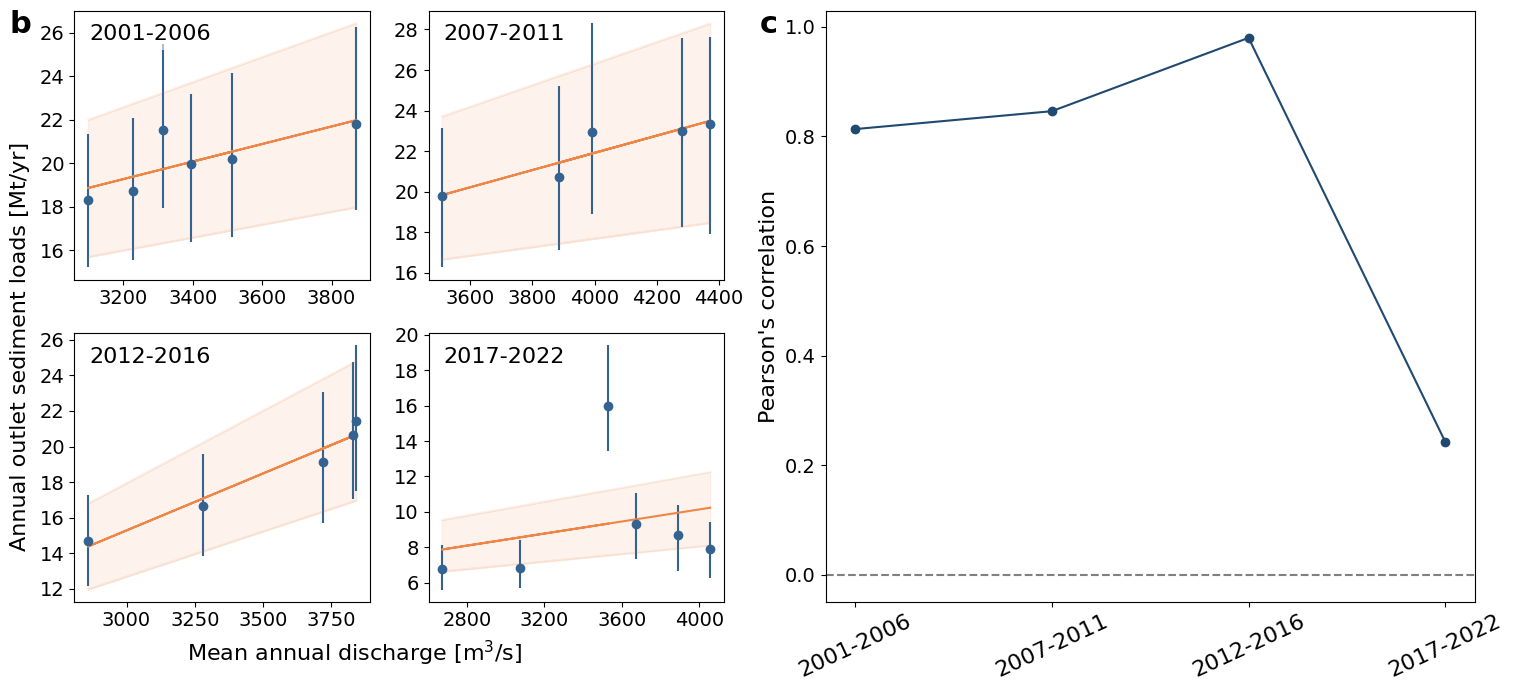

In [13]:
cmap = load_cmap("Hiroshige")
cmap = interpolate_cmap(cmap, 1000)

num_folders = 16

meandisch = np.zeros((num_folders, 23))
disch_95 = np.zeros((num_folders, 23))
outsed = np.zeros((num_folders, 23))

# Loop through folders
for folder_idx in range(1, num_folders + 1):
    folder_name = f'Results{folder_idx}'
    os.chdir(folder_name)
    
    discharge_file = '75STA.day'
    discharge_data = np.loadtxt(discharge_file, usecols=[3])

    start_date = datetime(2000, 1, 1)
    end_date = datetime(2022, 12, 31)
    date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

    assert len(discharge_data) == len(date_range), "Mismatch between dates and discharge data!"

    discharge_df = pd.DataFrame({'date': date_range, 'discharge': discharge_data})
    discharge_df['year'] = discharge_df['date'].dt.year

    meandisch[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].mean().values
    disch_95[folder_idx-1, :] = discharge_df.groupby('year')['discharge'].quantile(0.95).values
    
    sediment_file = 'totsedyear.csv'
    sediment_load = pd.read_csv(sediment_file, header=None).squeeze().values
    outsed[folder_idx-1, :] = sediment_load
    
    assert len(meandisch[folder_idx-1]) == len(sediment_load), "Mismatch in data lengths!"
    os.chdir('..')

#  Calculation of the Median and Percentiles Across Folders for Each Year
meandisch_median = np.median(meandisch, axis=0)
meandisch_5 = np.percentile(meandisch, 5, axis=0)
meandisch_95 = np.percentile(meandisch, 95, axis=0)

outsed_median = np.median(outsed, axis=0)
outsed_5 = np.percentile(outsed, 5, axis=0)
outsed_95 = np.percentile(outsed, 95, axis=0)

blocks = [(2001, 2006), (2007, 2011), (2012, 2016), (2017, 2022)]
anni = np.arange(2000, 2023)
correlations = []
time_periods = []

# Creation of the Figure with a 1x2 Grid
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Creation of a 2x2 Grid Inside the First Subplot
gs_left = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0], wspace=0.2, hspace=0.2)
sub_axes = [fig.add_subplot(gs_left[i, j]) for i in range(2) for j in range(2)]


for i, (start, end) in enumerate(blocks):
    mask = (anni >= start) & (anni <= end)
    
    x_median = meandisch_median[mask]
    x_5 = meandisch_5[mask]
    x_95 = meandisch_95[mask]
    y_median = outsed_median[mask]
    y_5 = outsed_5[mask]
    y_95 = outsed_95[mask]
    ax = sub_axes[i]
    #plt.subplot(2, 3, s)
    ax.errorbar(x_median, y_median, yerr=[y_median - y_5, y_95 - y_median], fmt='o', label=f"Points {start}-{end}", color=cmap(0.9))
    
    for x, y, color, alpha, model_dict in zip([x_median, x_5, x_95], [y_median, y_5, y_95], [cmap(0.1), cmap(0.1), cmap(0.1)], [1.0, 0.1, 0.1], 
                                               [None, models_x5, models_x95]):
        X = sm.add_constant(x)
        model = sm.OLS(y, X).fit()
        


        
        ax.plot(x, model.predict(X), color=color, alpha=alpha)
        if model_dict is not None:
            model_dict[(start, end)] = model

    x_min, x_max = x_5.min(), x_95.max()
    x_range = np.linspace(x_min, x_max, 100)
    ax.fill_between(x_range, models_x5[(start, end)].predict(sm.add_constant(x_range)), 
                     models_x95[(start, end)].predict(sm.add_constant(x_range)), color = cmap(0.1),alpha=0.1)
    X = sm.add_constant(x_median)
    model = sm.OLS(y_median, X).fit()
    # Computing the correlation
    correlation = np.corrcoef(x, y)[0, 1]
    correlations.append(correlation)
    time_periods.append(f"{start}-{end}")
    ax.text(0.05, 0.95, f"{start}-{end}", transform=ax.transAxes, fontsize=16, 
        verticalalignment='top', horizontalalignment='left', 
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    ax.tick_params(axis='both', labelsize=14)
    #ax.tick_params(axis='x', labelrotation=15) 
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5, integer=True)) 
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))


    
    

    

# Axis Labels (Only Once)
fig.text(0.22, 0.05, "Mean annual discharge [m$^3$/s]", ha='center', fontsize=16)
fig.text(-0.01, 0.5, "Annual outlet sediment loads [Mt/yr]", va='center', rotation='vertical', fontsize=16)

# Second Cell: Correlation Plot
ax_corr = fig.add_subplot(gs[1])
ax_corr.plot(time_periods, correlations, marker='o', linestyle='-', color=cmap(0.99))
ax_corr.axhline(y=0, color='gray', linestyle='--')
ax_corr.set_xticks(range(len(time_periods)))
ax_corr.set_xticklabels(time_periods, rotation=25, fontsize=16)
ax_corr.set_ylabel("Pearson's correlation", fontsize=16)
ax_corr.tick_params(axis='y', labelsize=14)



plt.tight_layout()
plt.text(-0.01, 0.98, 'b', fontsize=22, ha='left', va='top', fontweight='bold', transform=plt.gcf().transFigure)
plt.text(0.49, 0.98, 'c', fontsize=22, ha='left', va='top', fontweight='bold', transform=plt.gcf().transFigure)
fig.savefig('Figure2bc.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()